# Youtube Content Creator Analysis

#### Step 1: Define Why
Why am I doing this analysis?
- To find good practices from successful Youtube Channels to create a successful Youtube Channel

What is the Scope?
- Comparing only Data Analysis Channel Youtubers

#### Step 2: Get Channel Data

In [1]:
# Import required packages
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import config
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Prepare Youtube API
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=config.api_key)

In [3]:
# Choose current popular channels to analyse (via Channel ID)
## Tips to get Channel ID > go to Youtuber Channel Page > View Page Source > Line Wrap > Find channel_id > 2nd item
channel_1 = 'UC2UXDak6o7rBm23k3Vv5dww' # Tina Huang
channel_2 = 'UC7cs8q-gJRlGwj4A8OmCmXg' # Alex the Analyst
channel_3 = 'UCLLw7jmFsvfIVaUFsLs8mlQ' # Luke Barousse
channel_4 = 'UCiT9RITQ9PW6BhXK0y2jaeg' # Ken Jee
channel_5 = 'UCnz-ZXXER4jOvuED5trXfEA' # techTFQ
#  'UCDybamfye5An6p-j1t2YMsg' # Data With Mo
channel_ids = [channel_1, channel_2, channel_3, channel_4, channel_5]

In [4]:
# Function to get channel statistics
def get_channel_stats(youtube, channel_ids):
    
    # Prepare Youtube request
    request = youtube.channels().list(
                part ='snippet,contentDetails,statistics',
                id = ','.join(channel_ids) # to change list to string seoarated by ','
                )
    
    # Execute Youtube request and store response
    response = request.execute()

    # Store response in a list
    all_data = []
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
                )
        
        all_data.append(data)

    return all_data

In [5]:
# Run Function and store raw data
channel_statistics = get_channel_stats(youtube, channel_ids)

#### Step 3: Clean Channel Data

In [6]:
# Convert data to dataframe
channel_data = pd.DataFrame(channel_statistics)

In [7]:
# Preview data
channel_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,Ken Jee,246000,8242494,277,UUiT9RITQ9PW6BhXK0y2jaeg
1,techTFQ,215000,10735829,89,UUnz-ZXXER4jOvuED5trXfEA
2,Luke Barousse,360000,16624062,136,UULLw7jmFsvfIVaUFsLs8mlQ
3,Tina Huang,554000,24240319,127,UU2UXDak6o7rBm23k3Vv5dww
4,Alex The Analyst,520000,20912398,222,UU7cs8q-gJRlGwj4A8OmCmXg


In [8]:
# Check Data Types before conversion
channel_data.dtypes

Channel_name    object
Subscribers     object
Views           object
Total_videos    object
playlist_id     object
dtype: object

In [9]:
# Convert Data Types (to numeric)
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])


In [10]:
# Check Data Types after conversion
channel_data.dtypes

Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

In [11]:
# Export for PowerBI
channel_data.to_csv('ChannelData.csv')

#### Step 4: Understanding Channel Data

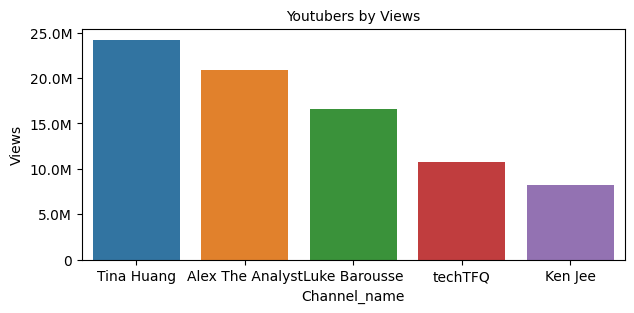

In [12]:
# Simple plot to understand data (Compare Youtubers via Views)

# sort data via views
channel_data_sort_by_views = channel_data.sort_values(by='Views', ascending=False) #sort df by views

# Function for Y axis formatting
def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    elif data_value == 0:
        formatter = '0'
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

# Chart settings
fig, ax = plt.subplots(figsize=(7,3))
plt.xticks(np.arange(0, max(channel_data.Views), 500000))
ax.yaxis.set_major_formatter(format_number)

chart = sns.barplot(x='Channel_name',y='Views',data=channel_data_sort_by_views)
chart.set_title('Youtubers by Views', fontdict ={'size': 'medium'}) # Set chart title and font size

plt.show()

Observation: Tina Huang Channel has highest number of views

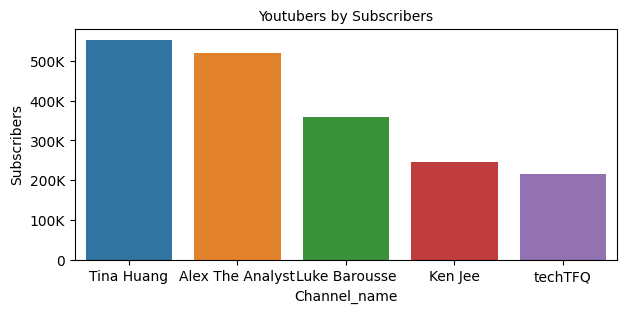

In [13]:
# Plot to understand data (Sort by subscribers)

# sort data via Subscribers
channel_data_sort_by_subscribers = channel_data.sort_values(by='Subscribers', ascending=False) #sort df by subscribers

# Function for Y axis formatting
def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    elif data_value == 0:
        formatter = '0'
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

# Chart settings
fig, ax = plt.subplots(figsize=(7,3))
plt.xticks(np.arange(0, max(channel_data.Views), 500000))
ax.yaxis.set_major_formatter(format_number)

chart = sns.barplot(x='Channel_name',y='Subscribers',data=channel_data_sort_by_subscribers)
chart.set_title('Youtubers by Subscribers', fontdict ={'size': 'medium'}) # Set chart title and font size

plt.show()

# sns.set(rc={'figure.figsize':(10,8)})
# ax = sns.barplot(x='Channel_name',y='Subscribers',data=channel_data)

Observation: Tina Huang has the highest number of Subscribers

In [14]:
# Find correlation between Views and Subscribers
var_Views = channel_data['Views']
var_Subscribers = channel_data['Subscribers']
np.corrcoef(var_Views, var_Subscribers)

array([[1.        , 0.96879277],
       [0.96879277, 1.        ]])

In [15]:
corr_channel_data = channel_data[['Views','Subscribers','Total_videos']]
corr_channel_data.corr()

,Views,Subscribers,Total_videos
Views,1.000000,0.968793,-0.253417
Subscribers,0.968793,1.000000,-0.010382
Total_videos,-0.253417,-0.010382,1.000000


Observation: Views are strongly correlated to Subscribers, Views are not correlated to Total Videos

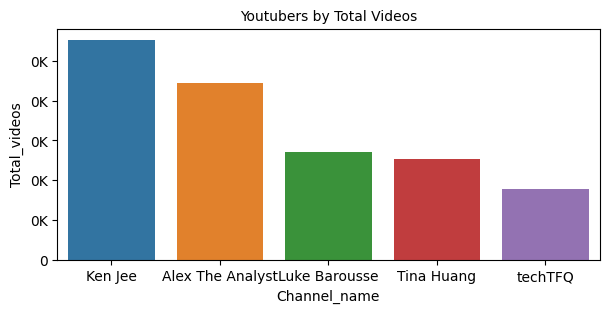

In [16]:
# Plot to understand data (Sort by Total_videos)

# Sort data via Total_videos
channel_data_sort_by_total_videos = channel_data.sort_values(by='Total_videos', ascending=False) #sort df by total videos

# Function for Y axis formatting
def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    elif data_value == 0:
        formatter = '0'
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

# Chart settings
fig, ax = plt.subplots(figsize=(7,3))
plt.xticks(np.arange(0, max(channel_data.Views), 500000))
ax.yaxis.set_major_formatter(format_number)

chart = sns.barplot(x='Channel_name',y='Total_videos',data=channel_data_sort_by_total_videos)
chart.set_title('Youtubers by Total Videos', fontdict ={'size': 'medium'}) # Set chart title and font size

plt.show()

# ax = sns.barplot(x='Channel_name',y='Total_videos',data=channel_data)

Observation: Tina Huang has second lowest total videos, but she has highest number of views and subscribers.

## Step 2: Get Video Data

In [17]:
# define which channel to get video data 
## (Temporary to work with 1 playlist, To-Do: to run whole list )
Channel_name_to_analyze = 'Tina Huang'
playlist_id = channel_data.loc[channel_data['Channel_name']==Channel_name_to_analyze, 'playlist_id'].iloc[0]
playlist_id

'UU2UXDak6o7rBm23k3Vv5dww'

In [18]:
# Define get_video_ids function
def get_video_ids(youtube, playlist_id):

    # Prepare request from youtube api
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50
                )
    
    # Execute request and store as response
    response = request.execute()

    # Store video ids in list
    video_ids = []
    for i in range (len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    #check for next page
    # print("nextPageToken(first part) = "+response.get('nextPageToken'))
    next_page_token = response.get('nextPageToken')
    more_pages = True
    while more_pages:
        #if no more pages, update more_pages variable to False
        if next_page_token is None:
            more_pages = False
        #if there are more pages, run the request with pageToken and append video_ids
        else:
            #run new request with page Token
            request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token
                )
            
            #execute new request
            response = request.execute()

            #loop through new video ids
            for i in range (len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            #update next_page_token for next round of while loop
            # print("nextPageToken second part= "+str(response.get('nextPageToken')))
            next_page_token = response.get('nextPageToken')
            # print(next_page_token)

    return video_ids

In [19]:
# Execute and store get_video_ids function
video_ids = get_video_ids(youtube, playlist_id)
video_ids

['ZPR1b58Fk_Q',
 'IaA-3FdWFm8',
 'EPKL7lsbLEk',
 'A6t6g_OoJhw',
 's1ONmED2u8s',
 'nXRNr7hoPK8',
 '12lV1HWchNQ',
 'NzytCGKMs3k',
 'pG_BwgjkFTk',
 'VznoKyh6AXs',
 'fr5l904EF58',
 'XLoMFXGTczU',
 'w8opECLgYQU',
 'I-4xBROt2Zc',
 'uzCTHdm0T_Q',
 'pwLaS7nPRxo',
 'tmXcKiVwJWg',
 'wGD_wmBZaE8',
 'fixfN8MNvoQ',
 '6hCS_ddArh4',
 'HTvwR8hLu9s',
 'UWQTIUSSVj4',
 'sS09Q-rKjos',
 'A3x0gYW42Ts',
 'egBzpILuNhA',
 'SQNzij5m_Yg',
 '8tpha6FIa_k',
 'UvqN3bAv0pM',
 'O90PZJUljOA',
 'jd9lEAqkp9Y',
 '9rGweuLdook',
 'oJDlPIVJZbw',
 '0QFh1expGNs',
 'Dw_ko_L232M',
 '_xf1TMs0ysk',
 'uQmjcGGCPGA',
 'dFApiK0kpUA',
 'd_RtvjDJGbY',
 'QKqjV6L5VRY',
 'aBkt_gIUP_c',
 '64OHAH0NbP8',
 'vKsaO5IetS0',
 'CL3GWyofdXY',
 'SrJzxalevjY',
 '_WHNz0pcEZw',
 'FYCXI0-S3Ug',
 'QlFV7LNPBEM',
 '0nBqRVNSIOg',
 'deIUUboTeig',
 'tF2h9UaRx7w',
 'Zk_w_qCnQnU',
 'KAVw910mIrI',
 '8_B2XA9uaGI',
 'mtgt1ElOo0U',
 '_5jlPHUWvpQ',
 'wKrxoau0NwE',
 'uJE_nOIetgE',
 'INymz5VwLmk',
 'DoFZtsV25Zw',
 'sOZ8MxFw8TQ',
 'XPYT8BaTqoA',
 'YUQ18uSrwqE',
 'qSlGAS

In [20]:
# Function to get video details
def get_video_details(youtube, video_ids):

    all_video_stats=[]

    for i in range (0, len(video_ids), 50):
        request = youtube.videos().list(
                    part='snippet,statistics',
                    id=','.join(video_ids[i:i+50]) #note that youtube limitation is max 50 
                    )
        
        response = request.execute()

        for video in response['items']:
            video_stats=dict(Title = video['snippet']['title'],
                             Published_date = video['snippet']['publishedAt'],
                             Views = video['statistics']['viewCount'],
                             Likes = video['statistics']['likeCount'],
                            #  Dislikes = video['statistics']['dislikeCount'], #no more dislikeCount
                             Comments = video['statistics']['commentCount']
                             )
            all_video_stats.append(video_stats)



    return all_video_stats

## Step 3: Clean Video Data

In [21]:
# Execute Function and store data in variable
video_details = get_video_details(youtube, video_ids)

In [22]:
# Create dataframe
video_data = pd.DataFrame(video_details)

In [23]:
# preview data
video_data

,Title,Published_date,Views,Likes,Comments
0,sick of it.,2023-07-07T00:15:01Z,10840,584,34
1,ChatGPT Prompts to Learn to Code Faster (and n...,2023-06-24T16:35:00Z,24230,1315,76
2,No insurance in 🇺🇸,2023-06-14T18:39:31Z,13366,335,37
3,When you need to study but also wanna watch an...,2023-06-04T17:53:08Z,7542,620,11
4,🐙 Lonely Octopus Career Design Training,2023-05-13T22:06:21Z,17768,814,39
...,...,...,...,...,...
122,"3rd Year Statistics, Data Science, Computer S...",2020-08-08T12:08:36Z,6982,192,24
123,How I Became a Data Scientist | Computer Scien...,2020-08-02T21:44:56Z,15758,448,41
124,How I got Software Engineering and Data Scienc...,2020-07-28T16:48:31Z,30534,1009,69
125,How to choose between software engineering and...,2020-07-22T06:00:57Z,383136,17354,667


In [24]:
# Check dataframe data type
video_data.dtypes

Title             object
Published_date    object
Views             object
Likes             object
Comments          object
dtype: object

In [25]:
# modify datetime
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])


In [26]:
# Check dataframe data type
video_data.dtypes

Title             object
Published_date    object
Views              int64
Likes              int64
Comments          object
dtype: object

## Step 4: Understanding Video Data

In [27]:
#top 10 videos
top10_videos = video_data.sort_values(by='Views', ascending = False).head(10)
top10_videos

,Title,Published_date,Views,Likes,Comments
77,How I would learn to code (if I could start over),2021-04-25,3252262,182244,2456
57,How I consistently study with a full time job ...,2021-10-09,2494110,109629,1970
80,How to self study technical things,2021-04-04,2261258,80046,1732
9,How to learn to code FAST using ChatGPT (it's ...,2023-03-02,1756270,62935,1589
13,How to Completely Transform Your Life in 6 Mon...,2023-01-01,865212,44669,636
59,Why you should not be a data scientist,2021-09-19,702951,20117,952
43,Techniques I use to be more disciplined and CO...,2022-02-03,634469,39730,632
11,Why You Will Pick the Wrong Career,2023-01-28,607896,31701,1092
60,Why I work so hard (despite having a ‘good’ job),2021-09-12,501094,22326,862
94,How to learn data science in 2022 (the minimiz...,2020-12-26,473379,21616,633


C:\Users\zdrag\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from current font.
  func(*args, **kwargs)
C:\Users\zdrag\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


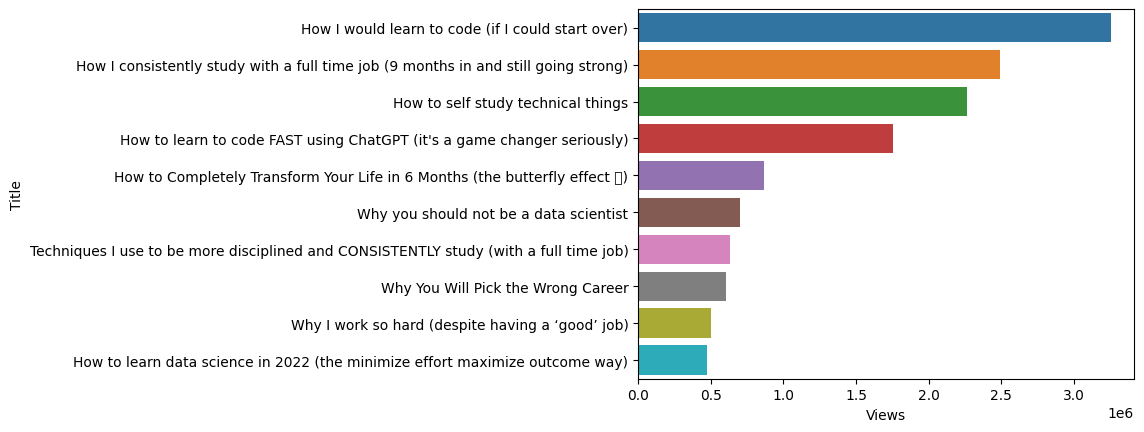

In [28]:
ax1 = sns.barplot(x='Views',y='Title',data=top10_videos)

In [29]:
video_data

,Title,Published_date,Views,Likes,Comments
0,sick of it.,2023-07-07,10840,584,34
1,ChatGPT Prompts to Learn to Code Faster (and n...,2023-06-24,24230,1315,76
2,No insurance in 🇺🇸,2023-06-14,13366,335,37
3,When you need to study but also wanna watch an...,2023-06-04,7542,620,11
4,🐙 Lonely Octopus Career Design Training,2023-05-13,17768,814,39
...,...,...,...,...,...
122,"3rd Year Statistics, Data Science, Computer S...",2020-08-08,6982,192,24
123,How I Became a Data Scientist | Computer Scien...,2020-08-02,15758,448,41
124,How I got Software Engineering and Data Scienc...,2020-07-28,30534,1009,69
125,How to choose between software engineering and...,2020-07-22,383136,17354,667


In [30]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [31]:
video_data

,Title,Published_date,Views,Likes,Comments,Month
0,sick of it.,2023-07-07,10840,584,34,Jul
1,ChatGPT Prompts to Learn to Code Faster (and n...,2023-06-24,24230,1315,76,Jun
2,No insurance in 🇺🇸,2023-06-14,13366,335,37,Jun
3,When you need to study but also wanna watch an...,2023-06-04,7542,620,11,Jun
4,🐙 Lonely Octopus Career Design Training,2023-05-13,17768,814,39,May
...,...,...,...,...,...,...
122,"3rd Year Statistics, Data Science, Computer S...",2020-08-08,6982,192,24,Aug
123,How I Became a Data Scientist | Computer Scien...,2020-08-02,15758,448,41,Aug
124,How I got Software Engineering and Data Scienc...,2020-07-28,30534,1009,69,Jul
125,How to choose between software engineering and...,2020-07-22,383136,17354,667,Jul


In [32]:
videos_per_month = video_data.groupby('Month', as_index=False).size()
videos_per_month

,Month,size
0,Apr,10
1,Aug,10
2,Dec,11
3,Feb,7
4,Jan,10
5,Jul,11
6,Jun,11
7,Mar,13
8,May,10
9,Nov,11


In [33]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [34]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

In [35]:
videos_per_month = videos_per_month.sort_index()

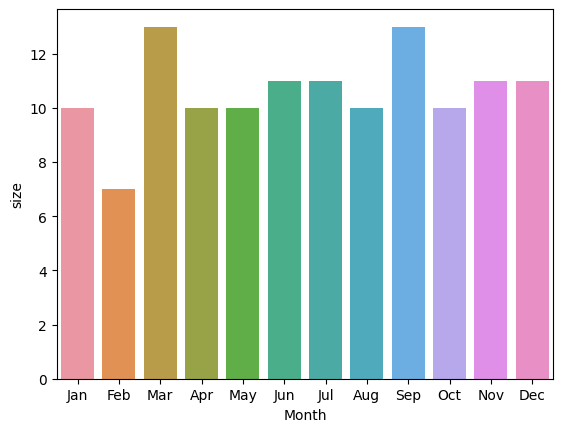

In [36]:
ax2 = sns.barplot(x='Month',y='size',data=videos_per_month)

In [38]:
# create csv
# To-do : make visualization in PowerBI/Tableau
csv_name = "Video_Details("+Channel_name_to_analyze+").csv"
video_data.to_csv(csv_name)